In [27]:
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

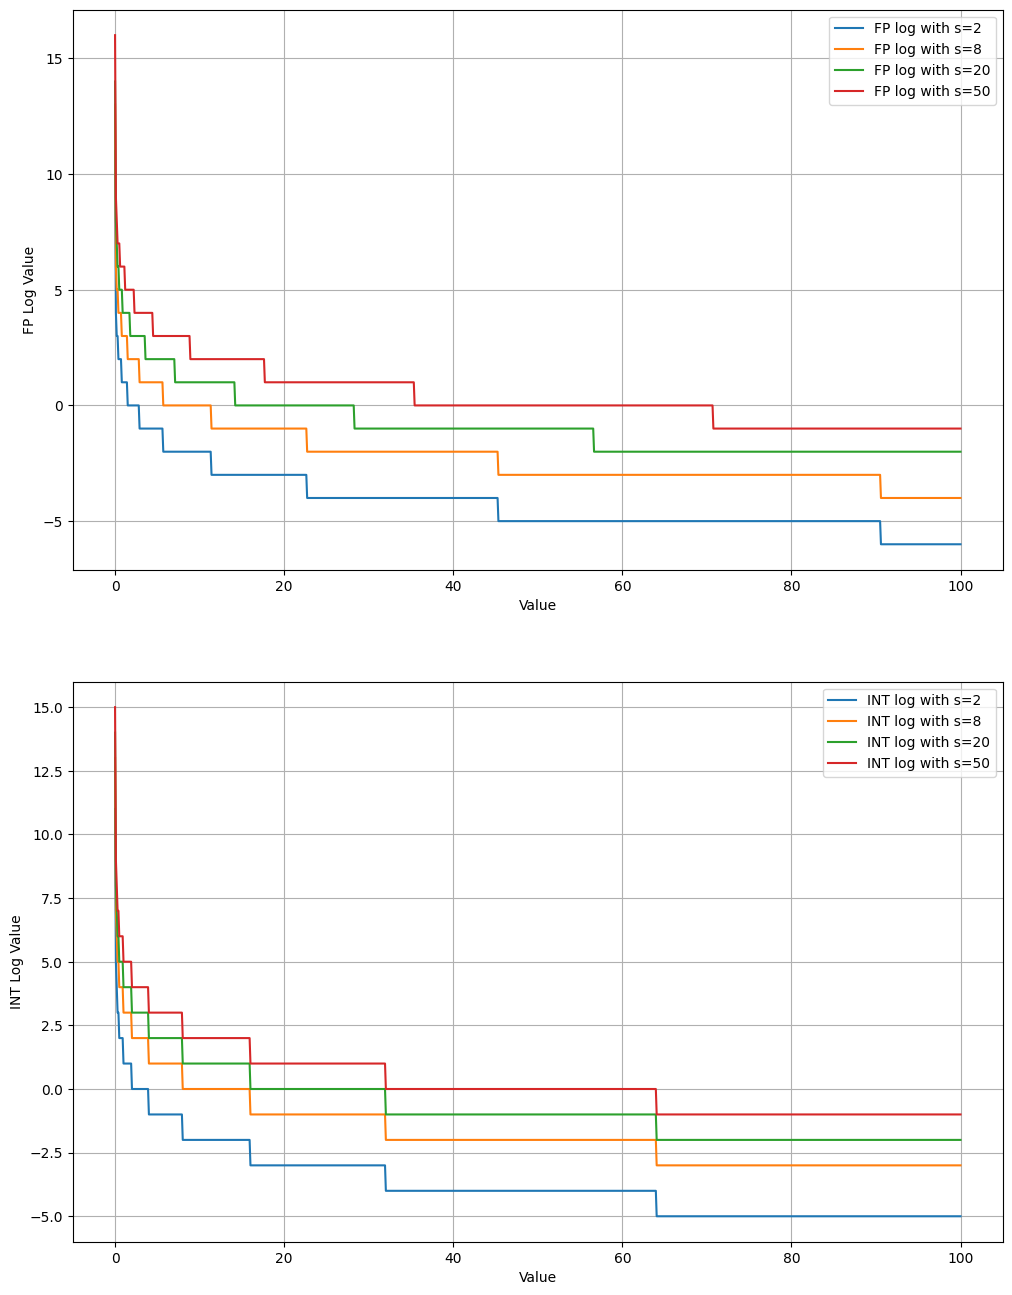

In [28]:
import numpy as np
import matplotlib.pyplot as plt


# log2 계산을 위한 함수 정의
def fplog(x, s):
    return -(np.round(np.log2(x) - np.log2(s)))


def intlog(x, s):
    return -(np.floor(np.log2(x)) - np.floor(np.log2(s)))


# x와 s의 값 범위 설정
x_vals = np.linspace(0.001, 100, 1000)


fig, ax = plt.subplots(2, 1, figsize=(12, 16))


x = torch.arange(1, 65535)
y = -x.clone().log2().floor()
s_vals = 2
ax[0].plot(x_vals, fplog(x_vals, s_vals), label="FP log with s=2")
s_vals = 8
ax[0].plot(x_vals, fplog(x_vals, s_vals), label="FP log with s=8")
s_vals = 20
ax[0].plot(x_vals, fplog(x_vals, s_vals), label="FP log with s=20")
s_vals = 50
ax[0].plot(x_vals, fplog(x_vals, s_vals), label="FP log with s=50")


s_vals = 2
ax[1].plot(x_vals, intlog(x_vals, s_vals), label="INT log with s=2")
s_vals = 8
ax[1].plot(x_vals, intlog(x_vals, s_vals), label="INT log with s=8")
s_vals = 20
ax[1].plot(x_vals, intlog(x_vals, s_vals), label="INT log with s=20")
s_vals = 50
ax[1].plot(x_vals, intlog(x_vals, s_vals), label="INT log with s=50")

ax[0].set_ylabel("FP Log Value")
ax[1].set_ylabel("INT Log Value")
for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel("Value")
    
    ax[i].grid(True)

In [29]:
def int_log_quant_10x(x):
    x = x.to(torch.int32)
    zero_mask = x == 0
    log2_int = torch.full_like(x, -1, dtype=torch.int32)

    temp_x = x.clone()
    for i in range(15, -1, -1):
        shift = 1 << i
        greater_equal = temp_x >= shift
        log2_int += greater_equal.to(torch.int32)
        temp_x = temp_x >> greater_equal.to(torch.int32)

    fractional_add = torch.zeros_like(x, dtype=torch.int32)

    temp_x = x - (1 << log2_int)
    temp_x = temp_x << 1  # temp_x *= 2
    fractional_add += (temp_x >= (1 << log2_int)).to(torch.int32) * 5
    out = -1 * (log2_int * 10 + fractional_add)
    out[zero_mask] = 99999
    return out

def int_log_dequant_10x(y):
    zero_mask = y == 99999
    y = -y
    """This OP requires the FP computation"""
    int_part = y // 10
    frac_part = y % 10 / 5

    int_num = 1 << int_part
    frac_num = frac_part * (1 << (int_part - 1))
    out = (int_num + frac_num).floor()
    out[zero_mask] = 0
    return out

In [30]:
_len = 195
res = int_log_quant_10x(torch.arange(0, _len))
out = int_log_dequant_10x(res)

for i, j ,k in zip(torch.arange(0, _len), res, out):
    print(i, j, k)

tensor(0) tensor(99999, dtype=torch.int32) tensor(0.)
tensor(1) tensor(0, dtype=torch.int32) tensor(1.)
tensor(2) tensor(-10, dtype=torch.int32) tensor(2.)
tensor(3) tensor(-15, dtype=torch.int32) tensor(3.)
tensor(4) tensor(-20, dtype=torch.int32) tensor(4.)
tensor(5) tensor(-20, dtype=torch.int32) tensor(4.)
tensor(6) tensor(-25, dtype=torch.int32) tensor(6.)
tensor(7) tensor(-25, dtype=torch.int32) tensor(6.)
tensor(8) tensor(-30, dtype=torch.int32) tensor(8.)
tensor(9) tensor(-30, dtype=torch.int32) tensor(8.)
tensor(10) tensor(-30, dtype=torch.int32) tensor(8.)
tensor(11) tensor(-30, dtype=torch.int32) tensor(8.)
tensor(12) tensor(-35, dtype=torch.int32) tensor(12.)
tensor(13) tensor(-35, dtype=torch.int32) tensor(12.)
tensor(14) tensor(-35, dtype=torch.int32) tensor(12.)
tensor(15) tensor(-35, dtype=torch.int32) tensor(12.)
tensor(16) tensor(-40, dtype=torch.int32) tensor(16.)
tensor(17) tensor(-40, dtype=torch.int32) tensor(16.)
tensor(18) tensor(-40, dtype=torch.int32) tensor(1

torch.Size([32, 6, 197, 197])
tensor(0., device='cuda:0') tensor(65142., device='cuda:0')


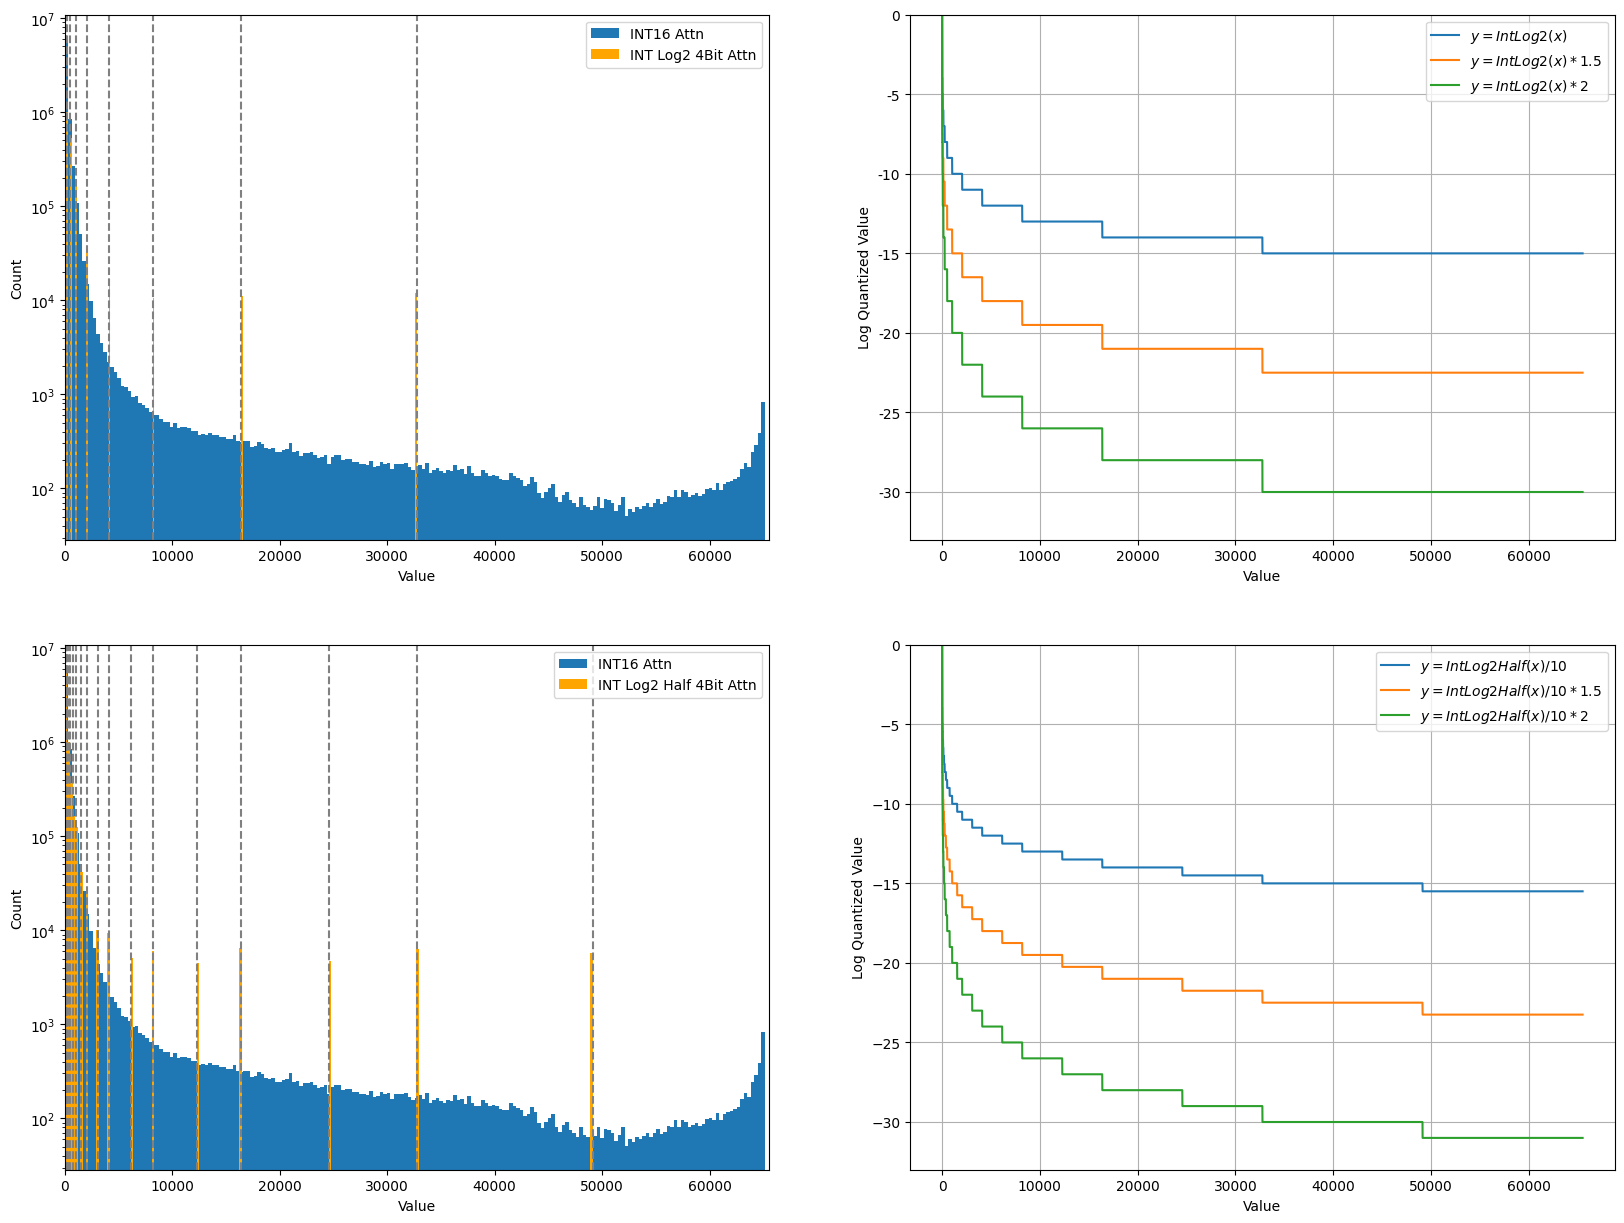

In [31]:
# x_int = torch.load("deit_base.pt")[:32]
x_int = torch.load("deit_small_1stAttn.pt")[:32]
print(x_int.shape)

print(x_int.min(), x_int.max())


fig, ax = plt.subplots(2, 2, figsize=(20, 15))
##################################################################################################################################################################################################################################################################################################################################################################################################################################################################
"""1st"""

x_log2_q = -1 * x_int.clone().log2().floor()
x_log2_dq = 2 ** (-x_log2_q)

x_int_hist = x_int.flatten().cpu().numpy()
x_int_out_hist = x_log2_dq.flatten().cpu().numpy()
ax[0][0].hist(x_int_hist, bins=200, label="INT16 Attn")
ax[0][0].hist(x_int_out_hist, bins=200, color="orange", label="INT Log2 4Bit Attn")


""" 2nd"""
x = torch.arange(1, 65535)
y_log2 = (int_log_quant_10x(x) / 10).ceil() 
ax[0][1].plot(x, y_log2, label=r"$y = {IntLog2}(x)$")
y2 = (int_log_quant_10x(x) / 10).ceil() * 1.5
ax[0][1].plot(x, y2, label=r"$y = {IntLog2}(x) * 1.5$")
y3 = (int_log_quant_10x(x) / 10).ceil() * 2
ax[0][1].plot(x, y3, label=r"$y = {IntLog2}(x) * 2$")

""" 1, 2 """
x_values_log2 = x_log2_dq.unique().cpu().numpy()
for tic in x_values_log2:
    ax[0][0].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")
    # ax[0][1].axvline(x=tic, color="gray", linestyle="--")  # , label=f"x={tic}")


##################################################################################################################################################################################################################################################################################################################################################################################################################################################################
""" 3rd"""

x_int_log_q = int_log_quant_10x(x_int.clone())
x_int_log_dq = int_log_dequant_10x(x_int_log_q)

x_int_hist = x_int.flatten().cpu().numpy()
x_int_out_hist = x_int_log_dq.flatten().cpu().numpy()
ax[1][0].hist(x_int_hist, bins=200, label="INT16 Attn")
ax[1][0].hist(
    x_int_out_hist, bins=200, color="orange", label="INT Log2 Half 4Bit Attn"
)


""" 4th"""
x = torch.arange(1, 65535)
y_log2 = (int_log_quant_10x(x)) / 10
ax[1][1].plot(x, y_log2, label=r"$y = {IntLog2Half}(x)/10$")
y2 = (int_log_quant_10x(x)) / 10 * 1.5
ax[1][1].plot(x, y2, label=r"$y = {IntLog2Half}(x)/10 * 1.5$")
y3 = (int_log_quant_10x(x)) / 10 * 2
ax[1][1].plot(x, y3, label=r"$y = {IntLog2Half}(x)/10 * 2$")

"""3, 4"""
x_values_log2_half = x_int_log_dq.unique().cpu().numpy()
for tic in x_values_log2_half:
    ax[1][0].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")
    # ax[1][1].axvline(x=tic, color="gray", linestyle="--")#, label=f"x={tic}")


ax[0][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))


for i, j in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    if j ==0:
        """for hist"""
        ax[i][j].set_yscale("log")
        ax[i][j].set_ylabel("Count")
        ax[i][j].set_xlim(0, 65535)
    else:
        ax[i][j].set_ylabel("Log Quantized Value")
        ax[i][j].set_ylim(-33, 0)
        ax[i][j].grid(True)
    ax[i][j].legend()
    ax[i][j].set_xlabel("Value")


plt.show()

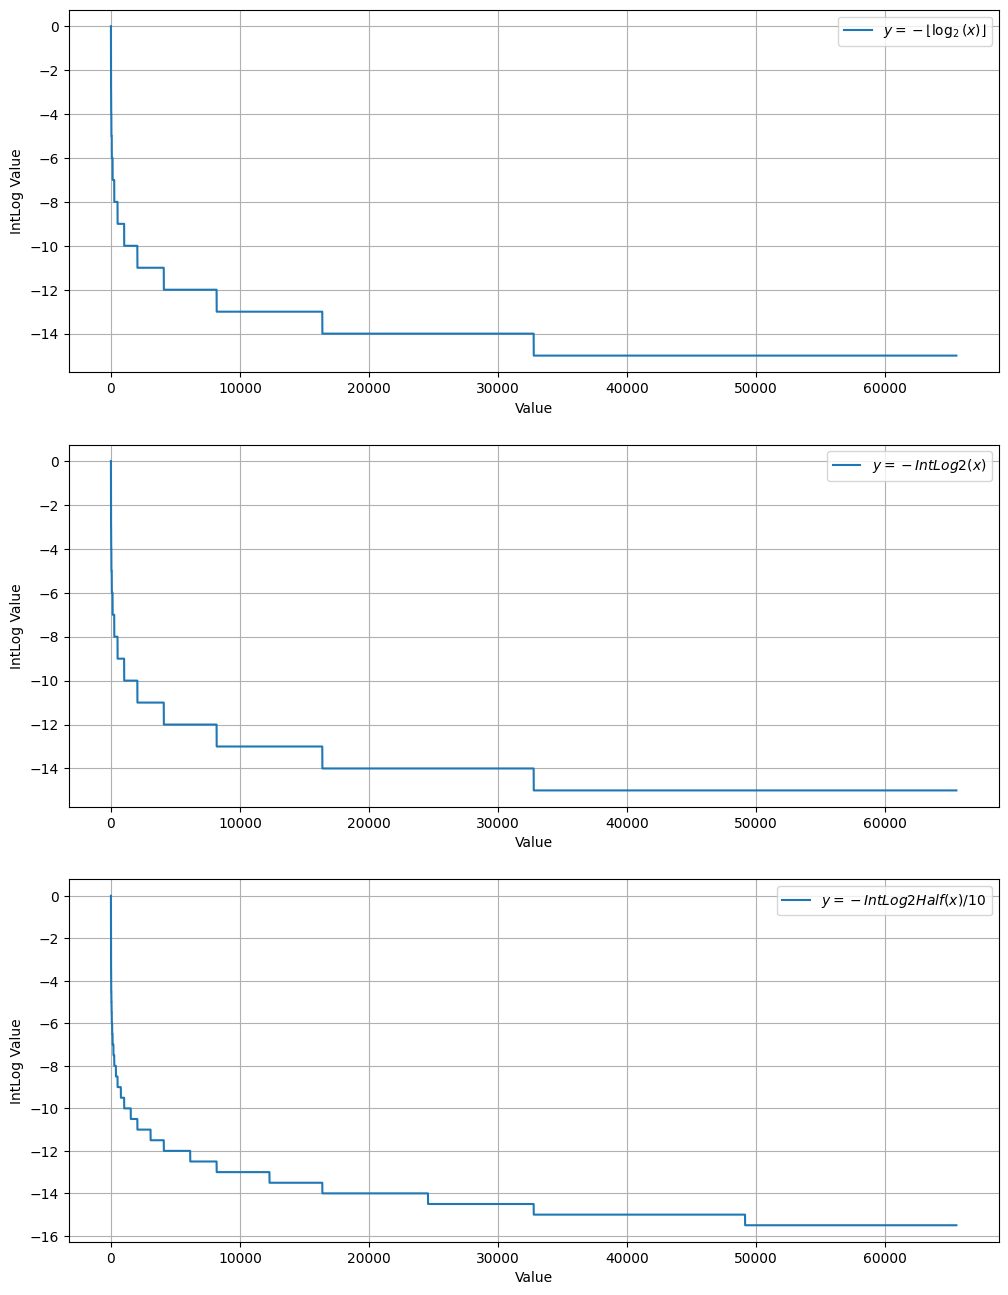

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(12, 16))


x = torch.arange(1, 65535)
y = -x.clone().log2().floor()
ax[0].plot(x, y, label=r"$y = -\lfloor\log_2(x)\rfloor$")
y_log2 = (int_log_quant_10x(x) / 10).ceil()
ax[1].plot(x, y_log2, label=r"$y = -{IntLog2}(x)$")
y_log2half = (int_log_quant_10x(x)) / 10
ax[2].plot(x, y_log2half, label=r"$y = -{IntLog2Half}(x)/10$")

for i in range(3):
    ax[i].legend()
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("IntLog Value")
    ax[i].grid(True)

In [33]:
dequantlog2 = 2**-y_log2
dequantlog2.unique()

tensor([1.0000e+00, 2.0000e+00, 4.0000e+00, 8.0000e+00, 1.6000e+01, 3.2000e+01,
        6.4000e+01, 1.2800e+02, 2.5600e+02, 5.1200e+02, 1.0240e+03, 2.0480e+03,
        4.0960e+03, 8.1920e+03, 1.6384e+04, 3.2768e+04])

In [34]:
(dequantlog2 * 256 // 32768).unique()

tensor([  0.,   1.,   2.,   4.,   8.,  16.,  32.,  64., 128., 256.])

In [35]:
(dequantlog2 * 255 / 32768).round().unique()

tensor([  0.,   1.,   2.,   4.,   8.,  16.,  32.,  64., 128., 255.])

In [36]:
(dequantlog2 * 255 // 32768).round().unique()

tensor([  0.,   1.,   3.,   7.,  15.,  31.,  63., 127., 255.])

In [37]:
(dequantlog2 * 255 // 32768).floor().unique()

tensor([  0.,   1.,   3.,   7.,  15.,  31.,  63., 127., 255.])